# Выбор локации для скважины

Добывающая компании «ГлавРосГосНефть». 

Цель проекта: где бурить новую скважину.

Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. 

Задача: Построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализировать возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

# Описание данных

Данные геологоразведки трёх регионов находятся в файлах: 
* `/datasets/geo_data_0.csv.`
* `/datasets/geo_data_1.csv.` 
* `/datasets/geo_data_2.csv.`
* id — уникальный идентификатор скважины;
* f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
product — объём запасов в скважине (тыс. баррелей).

**Условия задачи:**
* Для обучения модели подходит только **линейная регрессия** (остальные — недостаточно предсказуемые).
* При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают **200 лучших для разработки.**
* Бюджет на разработку скважин в регионе — **10 млрд рублей.**
* При нынешних ценах один баррель сырья приносит **450 рублей дохода.** Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
* После оценки рисков нужно оставить лишь те регионы, в которых **вероятность убытков меньше 2.5%.** Среди них выбирают регион с наибольшей средней прибылью.

## Загрузка и подготовка данных

### Импортируем библиотеки и сохраняем данные 

1. Импортируем библиотеки pandas, numpy, matplotlib, seaborn, stats, sklearn и другие. 

2. Для решения первой задачи cчитаем данные из csv-файлов и сохраним в переменные `geo_data_0, geo_data_1, geo_data_2` соответственно. Путь к файлам: `/datasets/geo_data_0.csv`, `/datasets/geo_data_2.csv`. 

4. В качестве разделителя в файлах используется знак `запятая`. В качестве разделителя десятичной части укажем `точку` методом `decimal='.'

In [1]:
# Импорт из стандартной библиотеки
import os
import warnings

# Стандартные библиотеки для научных вычислений
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind

# Визуализация данных
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import itertools

# Расчет статистик
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import (
    StratifiedKFold,
    RandomizedSearchCV, 
    GridSearchCV,
    KFold
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OneHotEncoder,
    LabelEncoder,
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler,
    RobustScaler,
)

# Модели машинного обучения
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Константы
line_1 = '-'*125
line_2 = '_'*125
RANDOM_STATE = 42
TEST_SIZE = 0.25
NSAMPLES = 3

In [5]:
#Функция для считывания данных и сохранения в Датафреймы
def load_data(file_path, remote_url, sep=';', decimal=','):
    try:
        if os.path.exists(file_path):
            print(f'Загрузка данных из локального файла: {file_path}')
            return pd.read_csv(file_path, sep=sep, decimal=decimal)
        else:
            print(f'Загрузка данных из удаленного источника: {remote_url}')
            return pd.read_csv(remote_url, sep=sep, decimal=decimal)
    except Exception as e:
        # Если возникла ошибка, выводим сообщение об ошибке
        print('Загрузка произошла с ошибкой')
        error_message = str(e)

In [6]:
data_paths = [
    ['geo_data_0.csv','https://code.s3.yandex.net/datasets/geo_data_0.csv'],
    ['geo_data_1.csv', 'https://code.s3.yandex.net/datasets/geo_data_1.csv'],
    ['geo_data_2.csv','https://code.s3.yandex.net/datasets/geo_data_2.csv'],
]

# Используем список для хранения загруженных датафреймов
df = []

# Проходим по каждой паре путей в списке
for file_path, remote_url in data_paths:
    # Для последнего элемента в списке используем значения по умолчанию
    df.append(load_data(file_path, remote_url, sep=',', decimal='.'))

Загрузка данных из локального файла: geo_data_0.csv
Загрузка данных из локального файла: geo_data_1.csv
Загрузка данных из локального файла: geo_data_2.csv


In [7]:
# Возможность обращаться к датафреймам по именам, используйем словарь вместо списка
geo_data_0 = df[0]
geo_data_1 = df[1]
geo_data_2 = df[2]

### Проверяем данные на пропуски, дубликаты, аномалии

1. Просматриваем общую информацию по данным, выводим замечания. Просматриваем методом `describe()`, отмечаем аномалии.

2. Проверяем на пропуски. Заполняем пропуски или нет.

4. Находим дубликаты в датафрейме. Удаляем дубликаты.

#### Проверка общей информации по регионам

In [8]:
#Общая информация по данным из регионов 
geo_data_0.info()
geo_data_0.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


В таблице `geo_data_0` нет пропущенных значений. Имеет 5 колонок и 100 000 строк. Типы данных соответстуют значениям. 

In [9]:
#Общая информация по данным из регионов 
geo_data_1.info()
geo_data_1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


В таблице `geo_data_1` нет пропущенных значений. Имеет 5 колонок и 100 000 строк. Типы данных соответстуют значениям. 

In [10]:
#Общая информация по данным из регионов 
geo_data_2.info()
geo_data_2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


В таблице `geo_data_1` нет пропущенных значений. Имеет 5 колонок и 100 000 строк. Типы данных соответстуют значениям. 

#### Проверка на дубликаты и аномалии

In [11]:
#Дубликаты  
print(f'Количество дубликатов в таблице geo_data_0: {geo_data_0.duplicated().sum()}')
print(f'Количество дубликатов в таблице geo_data_1: {geo_data_1.duplicated().sum()}')
print(f'Количество дубликатов в таблице geo_data_2: {geo_data_2.duplicated().sum()}')

Количество дубликатов в таблице geo_data_0: 0
Количество дубликатов в таблице geo_data_1: 0
Количество дубликатов в таблице geo_data_2: 0


In [12]:
#Неявные дубликаты
geo_data_0.nunique()

id          99990
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64

In [13]:
#Неявные дубликаты
geo_data_1.nunique()

id          99996
f0         100000
f1         100000
f2         100000
product        12
dtype: int64

In [14]:
#Неявные дубликаты
geo_data_2.nunique()

id          99996
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64

Во всех трех регионах имеются дубликаты в `id`. Посмотрим на них и перезапишем дубликаты. Возможно ошиблись в названии точки бурения, так как остальные признаки различны. 

In [15]:
#Нахожу дубликаты и записываю их в новые датафремы
id_duplicat_0 =geo_data_0[geo_data_0.duplicated(subset='id')]
id_duplicat_1 = geo_data_1[geo_data_1.duplicated(subset='id')]
id_duplicat_2 = geo_data_1[geo_data_2.duplicated(subset='id')]

In [16]:
# Удаляю дубликаты из исходных таблиц
geo_data_0 = geo_data_0[~geo_data_0.duplicated(subset='id')]
geo_data_1 = geo_data_1[~geo_data_1.duplicated(subset='id')]
geo_data_2 = geo_data_2[~geo_data_2.duplicated(subset='id')]

In [17]:
dataframes = [geo_data_0, geo_data_1, geo_data_2]
new_rows_list = [id_duplicat_0, id_duplicat_1, id_duplicat_2]

In [18]:
for i, (df, new_rows) in enumerate(zip(dataframes, new_rows_list)):
    new_rows['id'] = new_rows['id'].astype(str) + "_1"  # Добавляем суффикс "_1"
    dataframes[i] = pd.concat([df, new_rows], ignore_index=True)  # Сохраняем обновленный DataFrame обратно в список
    print(dataframes[i].nunique())
geo_data_0, geo_data_1, geo_data_2 = dataframes

id         100000
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64
id         100000
f0         100000
f1         100000
f2         100000
product        12
dtype: int64
id         100000
f0         100000
f1         100000
f2         100000
product     99999
dtype: int64


Дубликаты исправлены. Данные мы не потеряли.

In [19]:
geo_data_0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [20]:
geo_data_1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [21]:
geo_data_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.001993,-0.002484,2.495074,94.997032
std,1.732718,1.731322,3.473426,44.749897
min,-9.168138,-10.848143,-11.970335,0.000000
25%,-1.162365,-1.174941,0.130269,59.448359
50%,0.009424,-0.009671,2.484236,94.917850
75%,1.158535,1.163504,4.858662,130.585544
max,9.115956,7.844801,16.739402,190.029838


В данных замечены очень большие и маленькие значениия. Стоит проверить на выбросы. 

#### Выбросы в данных

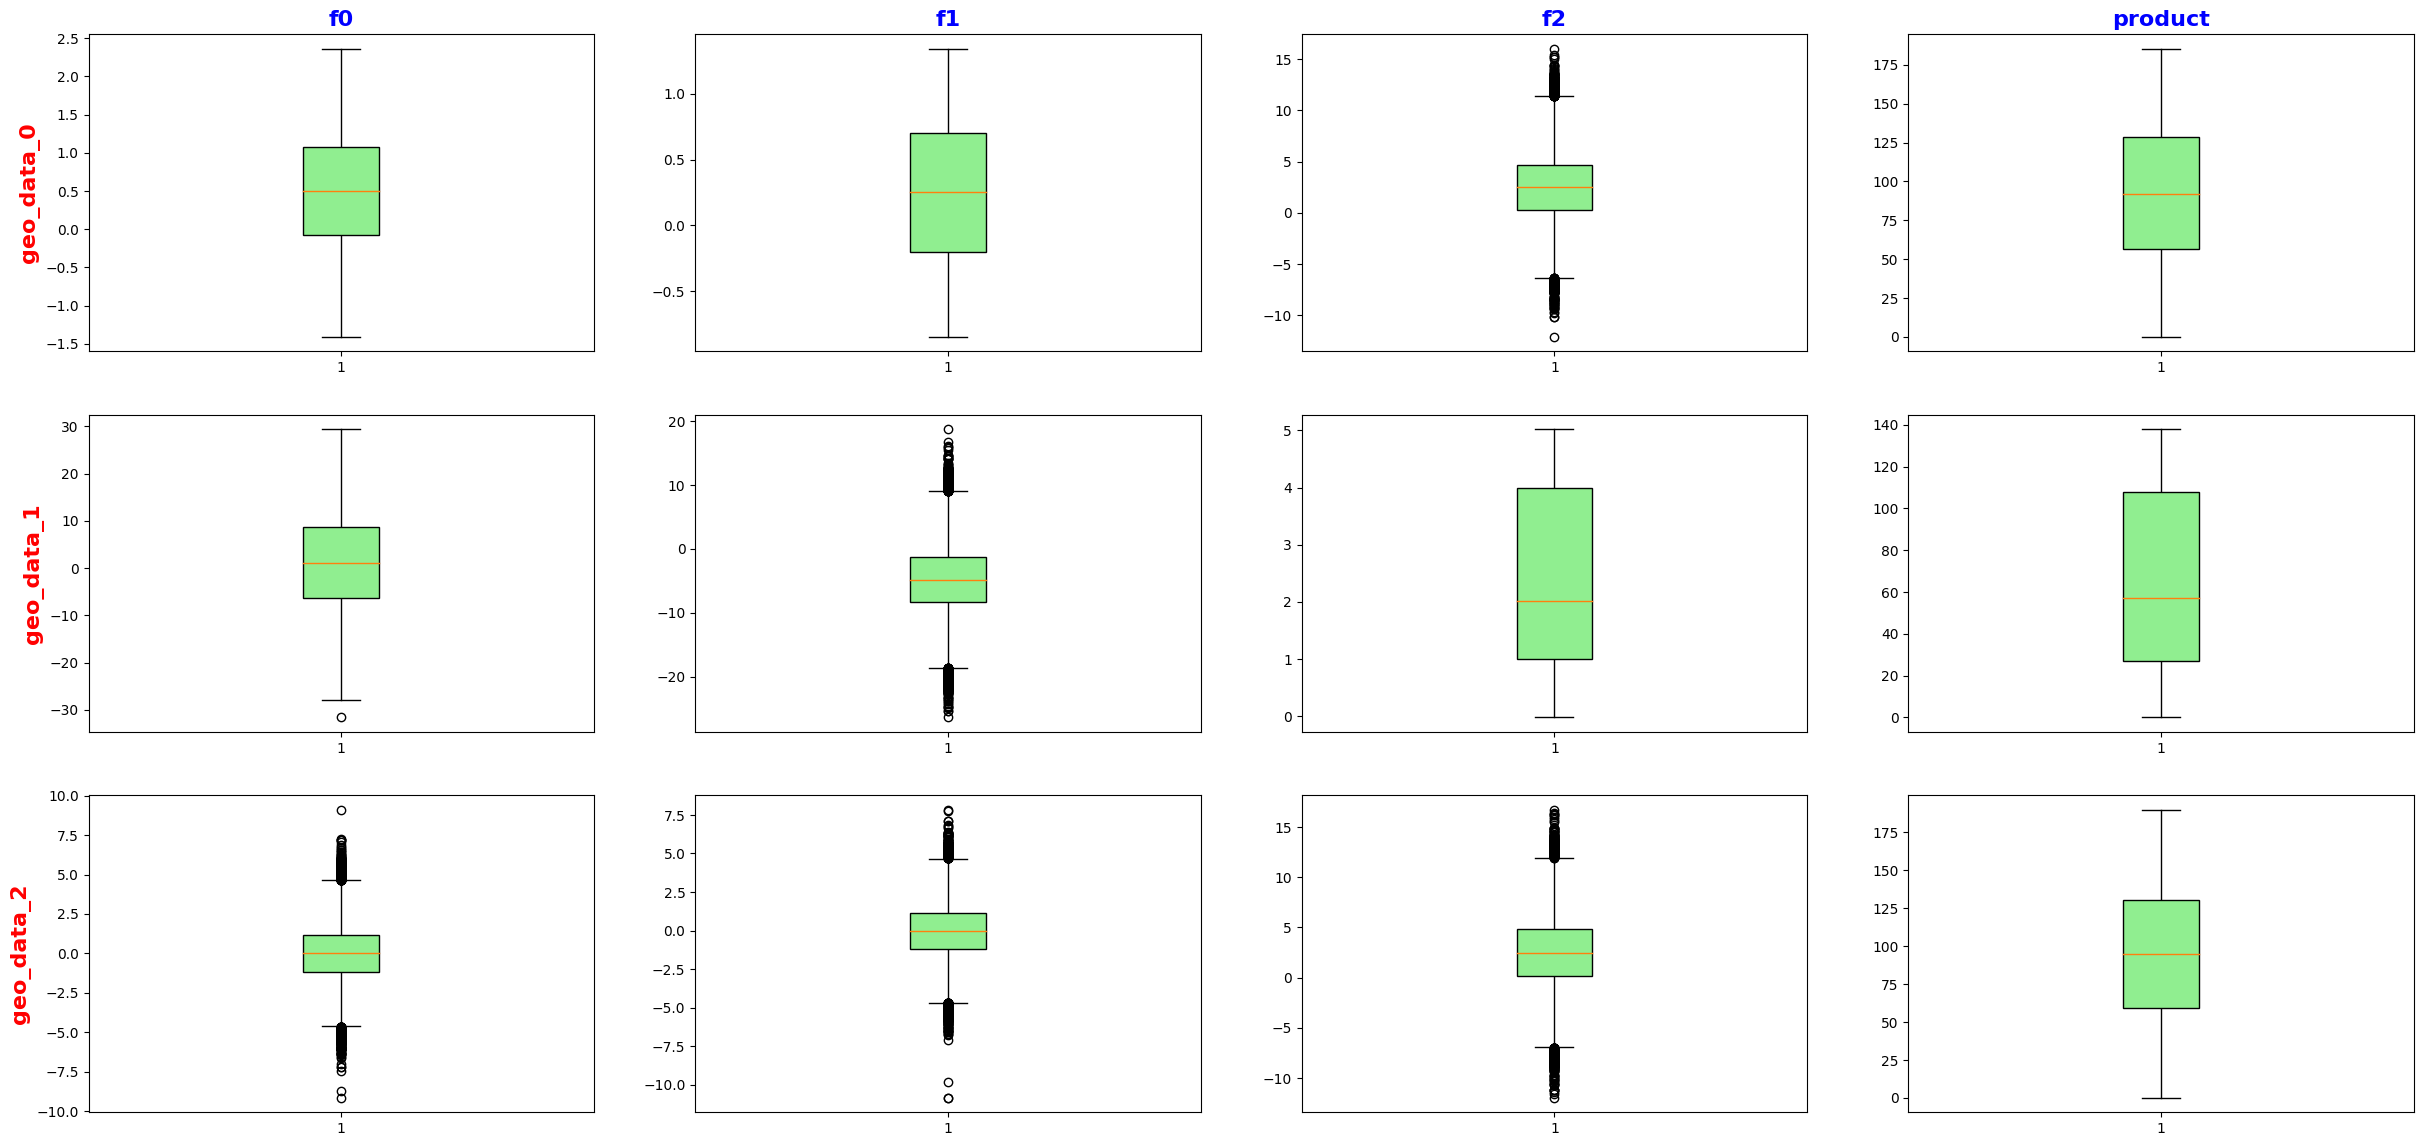

In [22]:
#Строим размерность
fig,ax = plt.subplots(3,4,figsize = (30,14))
# Создаю списки для прохода по данным
all_data = ['geo_data_0','geo_data_1','geo_data_2']
num_column = geo_data_0.columns[1:]
#Создаю соединения 
num_columns = zip(geo_data_0.columns[1:],range(4))
all_data_rows = zip([geo_data_0,geo_data_1,geo_data_2],range(3))
# Создаю цикл для каждого 
for column in list(itertools.product(all_data_rows,num_columns)):
    ax[column[0][1]][column[1][1]].boxplot(column[0][0][column[1][0]], patch_artist = True, boxprops = dict(facecolor = "lightgreen"))

for row in range(3):
    ax[row][0].set_ylabel(all_data[row], fontsize=16, fontweight="bold", color='red')

for column in range(4):
    ax[0][column].set_title(num_column[column], fontsize=16, fontweight="bold", color='blue')

* Таблица `geo_data_0` выбросы в `f2`
* Таблица `geo_data_1` выбросы в `f1`
* Таблица `geo_data_2` выбросы в `f0`, `f2`, `f1`

Я бы избавилась от выбросов в таблице. Выбросы могут значительно искажать результаты линейной регрессии. Поскольку линейная регрессия использует метод наименьших квадратов для минимизации суммы квадратов отклонений между предсказанными и фактическими значениями, выбросы могут привести к значительным изменениям в коэффициентах модели. Это может уменьшить точность модели и ее способность обобщать на новых данных.

In [23]:
def data_del_index(data, column):
    # Находим 1-й (Q1) и 3-й (Q3) квартили
    q25 = data[column].quantile(0.25)
    q75 = data[column].quantile(0.75)
    
    # Вычисляем межквартильный размах (IQR)
    iqr = q75 - q25
    
    # Определяем границы для выбросов
    lower_bound = q25 - 1.5 * iqr
    upper_bound = q75 + 1.5 * iqr
    
    # Находим индексы выбросов
    data_del_index = data[(data[column] < lower_bound) | (data[column] > upper_bound)].index.tolist()
    
    return data_del_index

In [24]:
#создаем кортеж из датафрема и колонки
data_x = [(geo_data_0,'f2'), (geo_data_1,'f0'), 
                  (geo_data_1,'f1'), (geo_data_2,'f0'), (geo_data_2,'f1'), (geo_data_2,'f2')]

In [25]:
#Для каждого значения применяем функцию и удаляем выюросы
for data, column in data_x:
    indexes = data_del_index(data,column)
    data.drop(indexes,axis = 0,inplace = True)

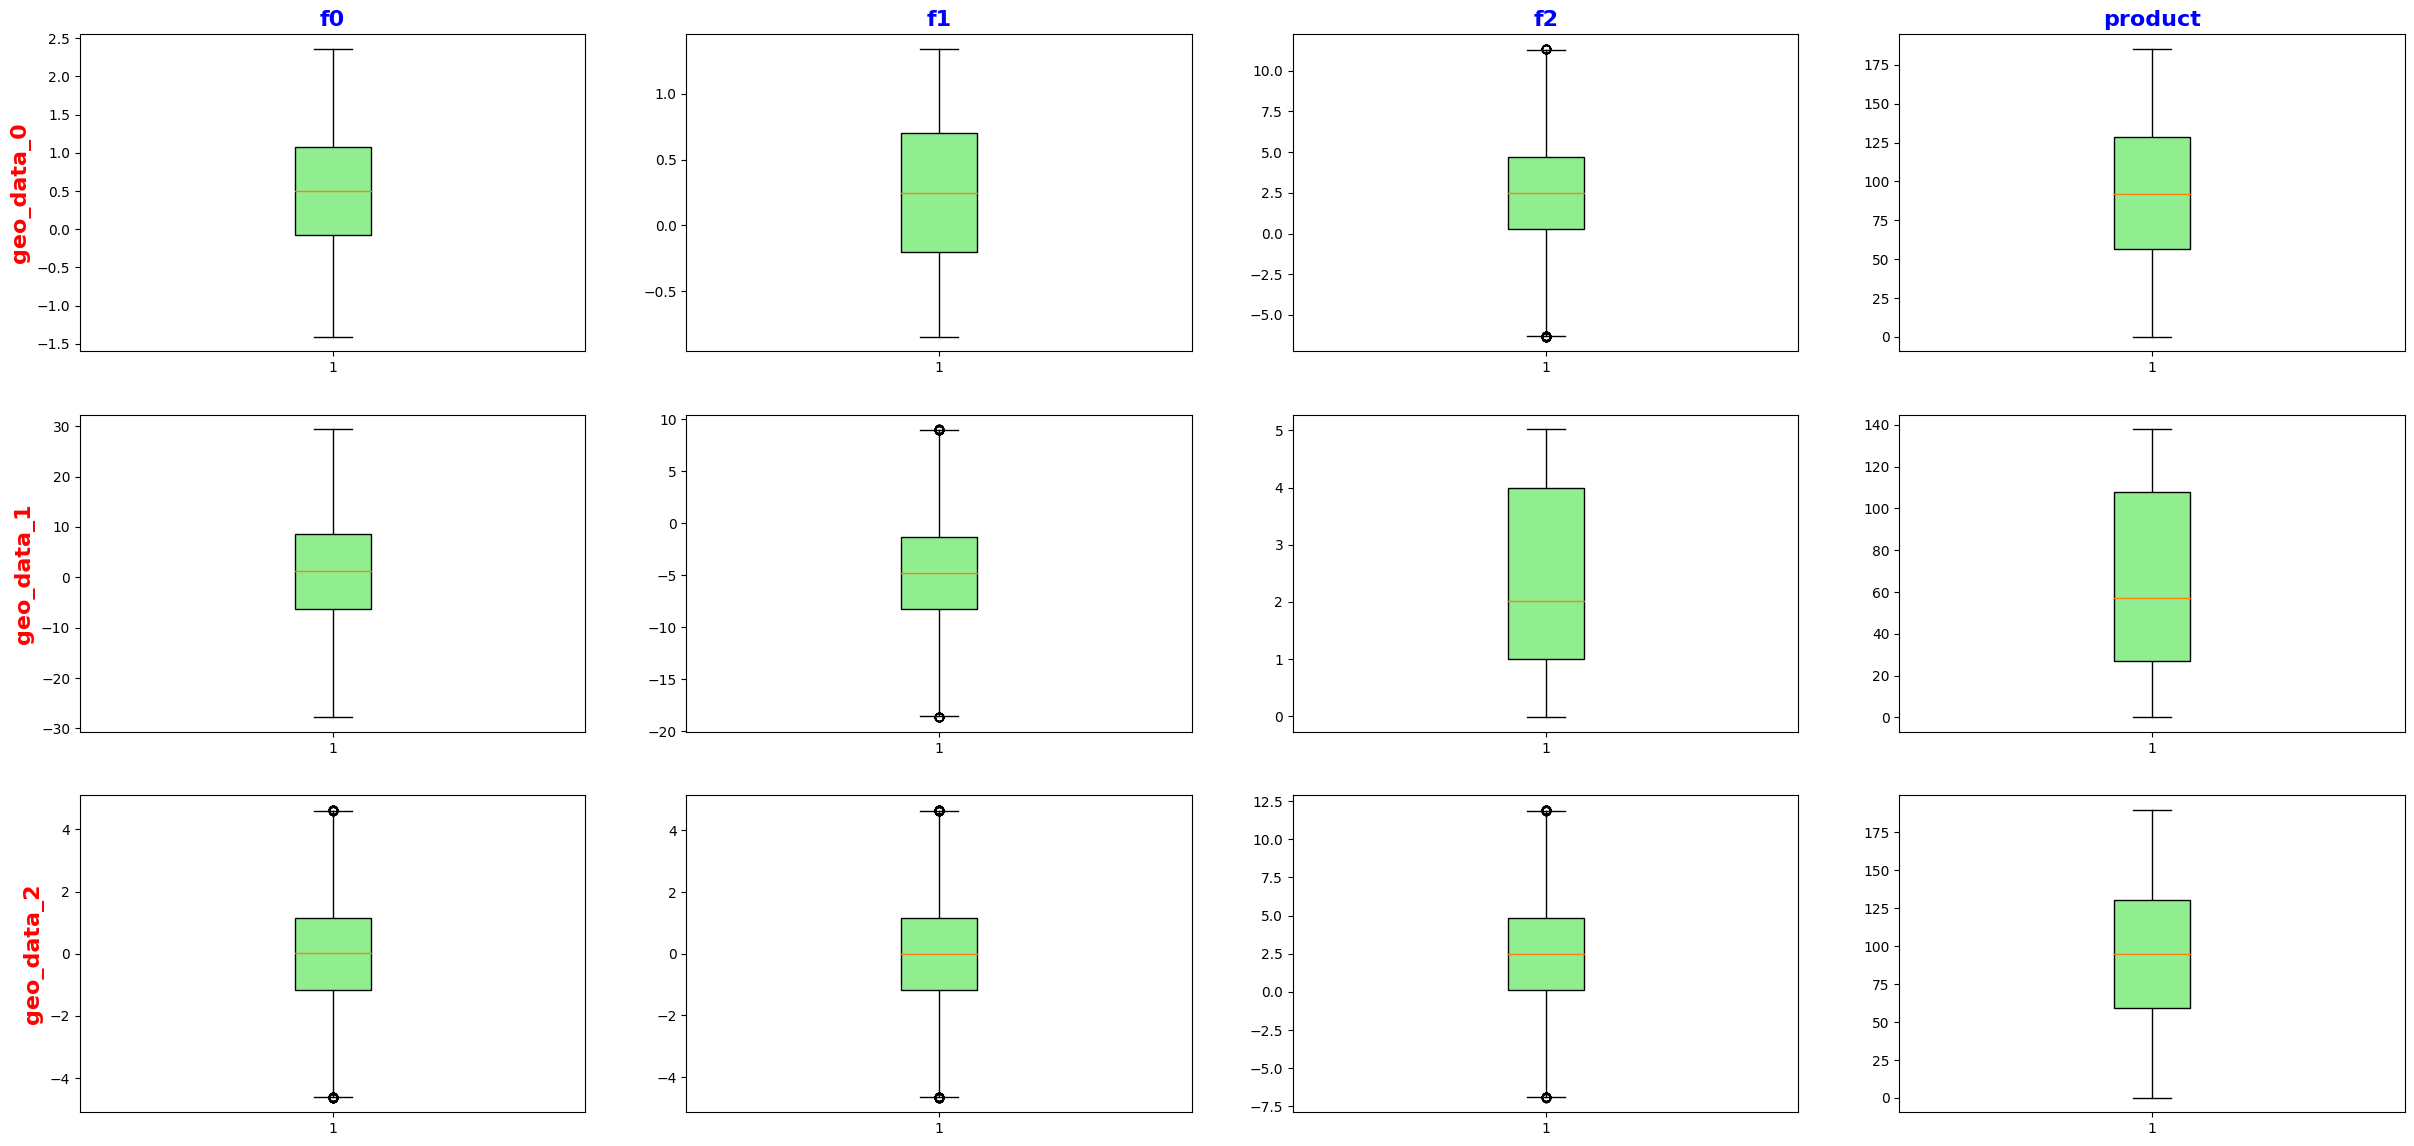

In [26]:
#Строим размерность
fig,ax = plt.subplots(3,4,figsize = (30,14))
# Создаю списки для прохода по данным
all_data = ['geo_data_0','geo_data_1','geo_data_2']
num_column = geo_data_0.columns[1:]
#Создаю соединения 
num_columns = zip(geo_data_0.columns[1:],range(4))
all_data_rows = zip([geo_data_0,geo_data_1,geo_data_2],range(3))
# Создаю цикл для каждого 
for column in list(itertools.product(all_data_rows,num_columns)):
    ax[column[0][1]][column[1][1]].boxplot(column[0][0][column[1][0]], patch_artist = True, boxprops = dict(facecolor = "lightgreen"))

for row in range(3):
    ax[row][0].set_ylabel(all_data[row], fontsize=16, fontweight="bold", color='red')

for column in range(4):
    ax[0][column].set_title(num_column[column], fontsize=16, fontweight="bold", color='blue')

Данные подготовлены для дальнейшего анализа и проверки на мультиколлинеарность. В данных имеется 100 000 строк и 5 столбцов. Изменены `id` дубликатов на такие же названия, но с окончание `_1`. Пропусков в данных нет. Выбросы удалены.

* Категориальных признаков в данных - нет. Кодирование не понадобиться.
* Мы будем работать с линейной регрессией, для нее маштабирование признаков не нужно.

### Мультиколлинеарность признаков и Визуализация 

Для дальнейшей работы нам нужно удалить `id` скважин. Так как в линейной регрессии этот признак нам не важен.

In [27]:
#Удаление id скважин с датасетов + создание единого для цикла
geo_0 = geo_data_0.drop(columns = ['id'])
geo_1 = geo_data_1.drop(columns = ['id'])
geo_2 = geo_data_2.drop(columns = ['id'])
data = [geo_0, geo_1, geo_2]

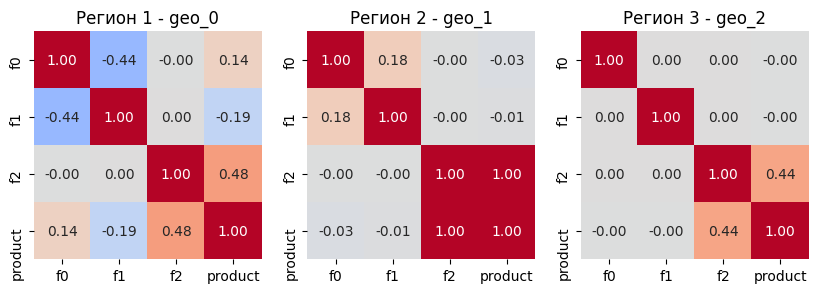

In [28]:
#Хитмэп для корреляции
fig = plt.figure(figsize = (10,5))
name = ['Регион 1 - geo_0', 'Регион 2 - geo_1', 'Регион 3 - geo_2']
for i in range(3): 
    ax = fig.add_subplot(1, 3, i+1)
    sns.heatmap(data[i].corr(), ax=ax, square=True, annot=True, fmt='.2f', vmax=1, vmin=-1, cbar=False, cmap='coolwarm')
    ax.set_title(name[i])

* Регион 1 -  _Умеренная корреляция_ между `product и f2` в **0.5**, а так же между `f1` и `f0`**-0.4**.
* Регион 2 - **Сильная линейная зависимость** между `f2` и `product` в **1**.
* Регион 3 - _Умеренная корреляция_ между `f2` и  `product` в **0.4**

Если корреляция Пирсона между зависимой и независимой переменной равна 1, это указывает на идеальную линейную зависимость. В таком случае линейная регрессия подходит, и мы можем ожидать, что модель будет хорошо объяснять изменчивость зависимой переменной.

#### Визуализация 

<Figure size 1600x800 with 0 Axes>

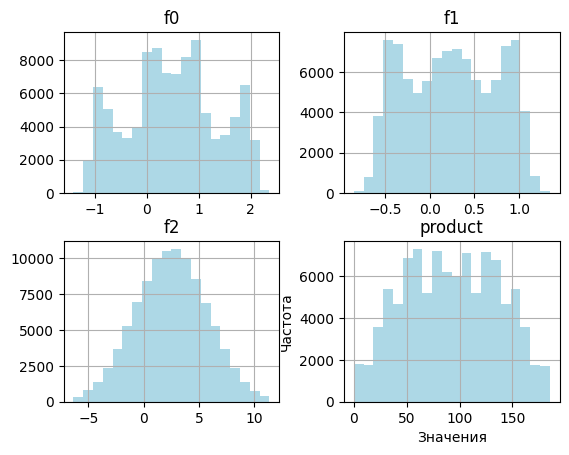

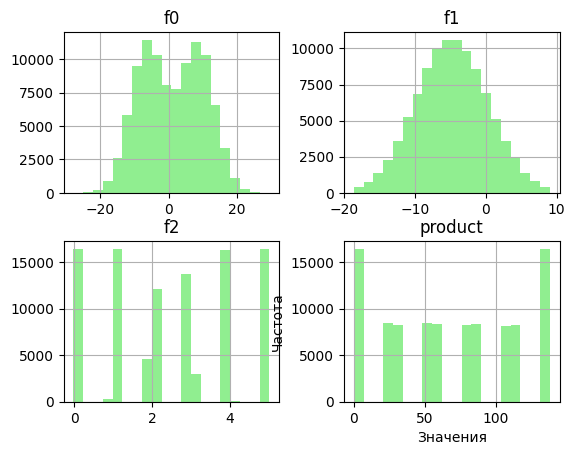

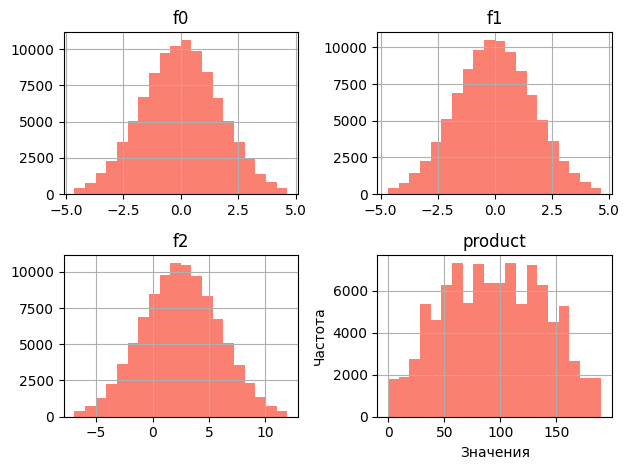

In [29]:
#Распределения
fig = plt.figure(figsize = (16,8));
colors = ['lightblue', 'lightgreen', 'salmon']
for i in range(3):
    data[i].hist(bins=20, color=colors[i])
    plt.xlabel('Значения')  # Название оси X
    plt.ylabel('Частота')   # Название оси Y

plt.tight_layout()  # Автоматическая настройка отступов
plt.show()

* Регион1 - нормальное распределение у `f2` и `product`.  `f1` и `f0` похоже на нормальное и частично биномадбльное распределения.
* Регион 2 - нормальное распределение у `f1` и с двумя пиками `f0`. Немного смущает распределение у `f2` и `product`. Больше похоже для кодировки на дискретную величину. И совсем не похоже на другие в данных других регионах.
* Регион 3 - все признаки нормально распределены.

In [30]:
# Создаем матрицу диаграмм рассеяния для еще одного способа посмотреть 
#axes = pd.plotting.scatter_matrix(
    #geo_0, 
    #figsize=(10, 10), 
    #color='magenta',  # Изменяем цвет на зеленый
    #alpha=0.3,  # Увеличиваем прозрачность для лучшей видимости
    #hist_kwds={'bins': 10, 'color': 'lightblue'}
#)

# Настраиваем оси
#for ax in axes.flatten():
    #ax.xaxis.label.set_rotation(0)
    #ax.yaxis.label.set_rotation(0)
    #ax.yaxis.label.set_ha('right')
    #ax.xaxis.label.set_fontweight('bold')  # Жирный шрифт для меток оси X
    #ax.yaxis.label.set_fontweight('bold')  # Жирный шрифт для меток оси Y

# Заголовок
#plt.suptitle(
    #'Матрица диаграмм рассеяния\nДанные геологоразведки Региона 1\n', 
    #fontsize=12, 
    #fontweight="bold", 
    #color='blue'  # Изменяем цвет заголовка
#)

# Убираем лишние отступы
#plt.subplots_adjust()

# Отображаем график
#plt.show()

#### Избавление от мультиколлинеарности 

Осталяю этот вопрос открытым. Пока не знаю стоит ли добавлять признаки или может вводить их в квадрат для избавления от корреляции

## Обучение и проверка модели

Задание для второго шага:
* Разбейте данные на обучающую и валидационную выборки в соотношении 75:25.
* Обучите модель и сделайте предсказания на валидационной выборке.
* Сохраните предсказания и правильные ответы на валидационной выборке.
* Напечатайте на экране средний запас предсказанного сырья и RMSE модели.
* Проанализируйте результаты.

In [31]:
# список предсказаний по объёму сырья в скважине на валидационной выборке
predictions_valid = []
# список правильных ответов на валидационной выборке
true_target = []
targets_valid = []

predictions_mean = []

In [32]:
#Создадим функцию для обучения модели, так как используем для всех регионов.

def step_2(data):
    # Выделим из переданного датасета
    # обучающие признаки features и целевой признак target: 
    X = data.drop(["product"], axis=1)
    y = data["product"]
    
    # Разобьём данные на обучающую и валидационную выборки в соотношении 75:25:    
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, 
        y,
        test_size=0.25,
        random_state=RANDOM_STATE)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_valid_scaled = scaler.transform(X_valid)
    
    # Создадим и обучим модель:
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)
    
# Cделаем предсказания на валидационной выборке:    
    predictions = model.predict(X_valid_scaled)

# список предсказаний по объёму сырья в скважине и список правильных ответов
    predictions_valid.append(predictions) 
    true_target.append(y_train.reset_index(drop=True))
    targets_valid.append(y_valid.reset_index(drop=True))
    predictions_mean.append(round(predictions.mean(),0)) 
    
# Напечатаем средний запас предсказанного сырья и RMSE модели:  
    print("Средний запас предсказанного сырья: {0:.2f} тыс. баррелей.". \
          format(predictions.mean()))
    print("RMSE модели: {0:.2f}.". \
          format((mean_squared_error(predictions, y_valid))**0.5))   
    

In [33]:
for i in range(3):
    print("\nРегион", i+1, "  Датасет geo_", i, ":")
    step_2(data[i])


Регион 1   Датасет geo_ 0 :
Средний запас предсказанного сырья: 92.70 тыс. баррелей.
RMSE модели: 37.49.

Регион 2   Датасет geo_ 1 :
Средний запас предсказанного сырья: 69.13 тыс. баррелей.
RMSE модели: 0.89.

Регион 3   Датасет geo_ 2 :
Средний запас предсказанного сырья: 95.01 тыс. баррелей.
RMSE модели: 39.99.


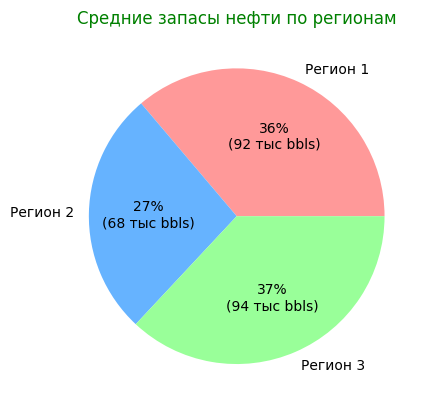

In [34]:
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.0f}%\n({:d} тыс bbls)".format(pct, absolute)

colors = ['#ff9999', '#66b3ff', '#99ff99'] 
labels = ['Регион 1', 'Регион 2', 'Регион 3']
fig, ax = plt.subplots()
ax.pie(predictions_mean, labels=labels,colors=colors, 
       autopct = lambda pct: func(pct, predictions_mean),)
ax.set_title("Средние запасы нефти по регионам", color='green')
plt.show();

**Вывод:**

На данном этапе провели обучение и проверку модели линейной регрессии предварительно разделив данные каждого региона на обучающую и валидационную выборки в соотношении 75:25. 

Привели признаки к единому масштабу для данных каждого региона.


Показано, что максимальный средний запас предсказанного сырья в 3-ем регионе с значением 95.01 тысяч баррелей

В данных 2-го региона RMSE близко к 0. Это произошло за счёт, фактически, прямой корреляции одного из признаков с целевым, замеченной нами ранее

## Подготовка к расчёту прибыли

Задание для 3 шага:
* Все ключевые значения для расчётов сохраните в отдельных переменных.
* Рассчитайте достаточный объём сырья для безубыточной разработки новой скважины.
* Сравните полученный объём сырья со средним запасом в каждом регионе. 
* Напишите выводы по этапу подготовки расчёта прибыли.

Условия задачи:

* Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
* При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
* Бюджет на разработку скважин в регионе — 10 млрд рублей.
* При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
* После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

In [35]:
# Создам основные переменные 
# При разведке региона исследуют 500 точек:
POINT = 500
BEST_POINT = 200
# Бюджет на разработку скважин в регионе — 10 млрд рублей:
BUDGET = 1e07 # в тыс рублей 
# Доход с каждой единицы продукта:
IN_COME = 450
# Количество выборок для метода Bootstrap
NUM_CIRCLE_BOOTATRAP = 1000 

In [33]:
#Рассчитайте достаточный объём сырья для безубыточной разработки новой скважины.
print("Точка безубыточности: {0:.0f} тыс. баррелей на каждый регион.\n". \
      format(BUDGET/ IN_COME))
print("Средний объем нефти в скважине, требуемый для безубыточной работы: {0:.0f} тыс. баррелей.". \
      format(BUDGET / IN_COME /BEST_POINT))

Точка безубыточности: 22222 тыс. баррелей на каждый регион.

Средний объем нефти в скважине, требуемый для безубыточной работы: 111 тыс. баррелей.


<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<h2> Комментарий ревьюера ✔️</h2>
    
Верно. 
</div>

In [34]:
#Сравнение полученного объёма сырья со средним запасом в каждом регионе.
df_result_predict = pd.DataFrame(columns=['Датасет',
                    'Средний запас предсказанного по валидационной выборке сырья (тыс. баррелей)']
)

for region in range(3):
    df_result_predict.loc[len(df_result_predict)] = \
        [f'регион_{region+1}:', 
         f'{predictions_valid[region].mean():.2f} < 111']

display(df_result_predict)


df_reserves = pd.DataFrame(columns=['Датасет',
                    'Среднее значение реального запасa сырья по полного кол-ву скважин в регионе (тыс. баррелей)']
)

for region in range(3):
    value = data[region]['product'].mean()
    df_reserves.loc[len(df_reserves)] = \
        [f'регион_{region+1}:', f'{value:.2f} < 111']

display(df_reserves)   

,Датасет,Средний запас предсказанного по валидационной выборке сырья (тыс. баррелей)
0,регион_1:,92.70 < 111
1,регион_2:,69.13 < 111
2,регион_3:,95.01 < 111


,Датасет,Среднее значение реального запасa сырья по полного кол-ву скважин в регионе (тыс. баррелей)
0,регион_1:,92.50 < 111
1,регион_2:,68.81 < 111
2,регион_3:,94.78 < 111


**Промежуточные результаты:**

* Среднее значение запаса сырья по всем скважинам для каждого из регионов меньше, чем точка безубыточности: 111 тыс. баррелей (объём сырья для безубыточной разработки новой скважины).
* Разработку всех скважин вести нерентабельно.
* Из всех скважин нужно выбрать всего 200 лучших с максимальными запасами и вкладывать деньги в их запуск и производственную деятельность.

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<h2> Комментарий ревьюера ✔️</h2>
    
Получается, даже средние истинные значения не достигают рассчитанного выше значения безубытка. Таким образом, мы пока не можем выбрать ни один из регионов. Здесь нам и помогут модели.
    
</div>

## Расчёт прибыли и рисков 

* Выбрать скважины с максимальными значениями предсказаний.
* Просуммировать целевое значение объёма сырья, соответствующее этим предсказаниям.
* Рассчитать прибыль для полученного объёма сырья.

In [36]:
# Создадим пустой датафрейм result, чтобы потом добавлять в него строками данные:
df_result_best_200 = pd.DataFrame(
            columns=['Регион',
            'Прибыль (млрд. руб)']
)

predict_200_best = [] # список с двумястами лучшими значениями запасов нефти 


# Функция расчёта прибыли
def calc_profit(target, predictions):
    predictions_sorted = predictions.sort_values(ascending=False)
    target_selected = target[predictions_sorted.index][:BEST_POINT]

    return target_selected.sum() * IN_COME - BUDGET


print("По 200-м лучшим скважинам:")
for region in range(3):
    predictions_sample = pd.Series(predictions_valid[region])      
    
    profit = calc_profit(targets_valid[region], predictions_sample)
    
    df_result_best_200.loc[len(df_result_best_200.index)] = \
        ["Регион " + str(i+1), profit/1000000]

display(df_result_best_200)  

По 200-м лучшим скважинам:


,Регион,Прибыль (млрд. руб)
0,Регион 3,3.121198
1,Регион 3,2.415087
2,Регион 3,2.424892


<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<h2> Комментарий ревьюера ✔️</h2>
    
Верно, сортировка идет по предсказаниям, но для вычисления прибыли следует использовать таргеты, т.к. предсказания могут не быть верными. 

</div>

Все 3 Региона имеют достаточно хорошую прибыль по 200 скважинам.

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<h2> Комментарий ревьюера ✔️</h2>
    
Да, тут важно подчеркнуть, что оценка идет лишь по 200 лучшим точкам. 

</div>

## Риски и прибыль для каждого региона

* Примените технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
* Найдите среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.
* Напишите выводы: предложите регион для разработки скважин и обоснуйте выбор.

In [37]:
from tqdm.auto import tqdm

In [38]:
RANDOM_FIX_NUMBER = 12345  # Введем глобальную переменную для значения random_state
STATE = np.random.RandomState(RANDOM_FIX_NUMBER)

In [40]:
# Создадим пустой датафрейм result, чтобы потом добавлять в него строками данные:

#print("По 200-м лучшим скважинам:")

df_result = pd.DataFrame(
            columns=['Датасет',
            'Средняя прибыль от 200 лучших скважин (млн. руб.)', 
            '95%-й доверительный интервал от 200 лучших скважин (млн. руб.)', 
            'Риск убытков при 200 лучших скважин (%)']
)
Y = []
#Для текущего региона извлекаются предсказания и целевые значения.
for region in range(3):
    predictions = predictions_valid[region]
    target = targets_valid[region]
#Инициализация списка для прибыли
    profit_values = []
    
#В этом цикле происходит бутстрэппинг — случайное выборка данных с возвращением.
#NUM_CIRCLE_BOOTATRAP — это количество итераций бутстрэппинга.
    for i in tqdm(range(NUM_CIRCLE_BOOTATRAP)):
        # выбираем 500 скважин:
        target_sample  = target.sample(POINT, replace=True, random_state=STATE)

        # выбираем соответствующие этим 500 скважинам предсказания:
        predictions_sample = predictions[target_sample.index]

        target_sample = target_sample.reset_index(drop = True)
        predictions_sample = pd.Series(predictions_sample)
        predictions_sample = predictions_sample.reset_index(drop = True)
              
        profit_values.append(calc_profit(target_sample, predictions_sample))
 
 #Здесь вычисляется средняя прибыль, доверительный интервал (2.5%-й и 97.5%-й квантили) 
#и риск убытков (доля отрицательных значений прибыли).

    profit_values = pd.Series(profit_values)
    mean_profit = (f'{round(profit_values.mean()/1000)}')
    confidence_interval = (f'{profit_values.quantile(0.025)/1000:.0f} ... ' 
                           f'{profit_values.quantile(0.975)/1000:.0f}') 
    risks = round((profit_values < 0).mean()*100, 1)
    Y.append(risks)    
# Результаты по текущему региону добавляются в DataFrame df_result.   
    df_result.loc[len(df_result)] = [f'регион_{region+1}:', 
                                     mean_profit, confidence_interval, f'{risks}']
  
display(df_result)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

,Датасет,Средняя прибыль от 200 лучших скважин (млн. руб.),95%-й доверительный интервал от 200 лучших скважин (млн. руб.),Риск убытков при 200 лучших скважин (%)
0,регион_1:,425,-117 ... 918,6.1
1,регион_2:,477,82 ... 891,0.8
2,регион_3:,341,-175 ... 844,10.6


<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<h2> Комментарий ревьюера ✔️</h2>
    
Правильно. Верно и то, что есть возвращение после сэмплирования. 
</div>

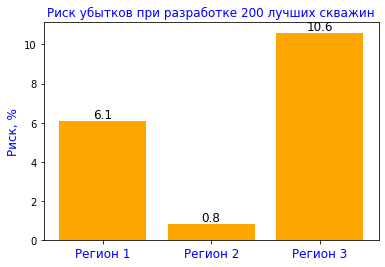

In [42]:
X = ['Регион 1', 'Регион 2', 'Регион 3']
c = ['orange']
plt.bar(X, Y, color=c)

# Добавление значений над столбцами
for i in range(len(Y)):
    plt.text(X[i], Y[i], float(Y[i]), 
             horizontalalignment='center', verticalalignment='bottom', 
             fontdict={'fontweight': 500, 'size': 12})

# Заголовок и подписи
plt.title("Риск убытков при разработке 200 лучших скважин", fontsize=12, color='blue')
plt.ylabel('Риск, %', fontsize=12, color='blue')

# Установка меток по оси X
plt.xticks(ticks=range(len(X)), labels=X, fontsize=12, color='blue')

# Показать график
plt.show()

* В регионе 2 (файл с исходными данными: 'geo_data_1.csv') вероятность убытков меньше 2.5%.
* Средняя прибыль в регионе 2 составляет более 450 млн рублей.
* Для региона 2 95%-й доверительный интервал не содержит отрицательных значений.

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<h2> Комментарий ревьюера ✔️</h2>
    
Визуализации лишними не бывают :)
</div>

<div class="alert alert-warning" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<h2> Комментарий ревьюера  ⚠️</h2>
    
Поскольку на оси Х уже есть подписи, разные цвета тут не нужны. С одной стороны, красиво, но с другой, это лишняя информация.     
</div>
<div class="alert alert-danger" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<h2> Комментарий ревьюера  ❌</h2>
    
Пожалуйста, не забывай и про общий вывод. Попробуй кратко перечислить результаты (что сделано) и выводы из них.

</div>

<div class="alert" style="border-radius: 15px; box-shadow: 4px 4px 10px rgba(0, 0, 0, 0.2); border: 1px solid #4A90E2; background-color: #F9F9F9;">  
    <h2 style="color: #4A90E2;">Комментарий студента 👤</h2> 
    
Исправлено. Цвета убраны.
</div>

## Общий вывод

Добывающая компании **«ГлавРосГосНефть».**

Цель проекта: где бурить новую скважину.

Задача: Построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализировать возможную прибыль и риски техникой *Bootstrap.*

**Что сделано**

_В первом шаге:_
* Мы импортировари библиотеки pandas, numpy, matplotlib, seaborn, stats, sklearn и другие. 
* Считывали данные из csv-файлов и сохраним в переменные `geo_data_0, geo_data_1, geo_data_2` соответственно. Путь к файлам: `/datasets/geo_data_0.csv`, `/datasets/geo_data_2.csv`. 
* Просматрели  общую информацию по данным. В данных по 3-м регионам имеются 5 столбцов и 10 000 строк. 
* Типы данных соответствуют указанным в таблице данным. Методом describe(), отметили аномалии и после удалили их.Пропусков в данных - нет.
* Во всех трех регионах имеются дубликаты в id. Перезаписали дубликаты. Причина перезаписи: Возможная ошибка в названии точки бурения, так как остальные признаки различны.
Данные подготовлены для дальнейшего анализа и проверки на мультиколлинеарность. 
* Категориальных признаков в данных - нет. Кодирование не понадобиться.
* Мы будем работать с линейной регрессией. Следовательно удаляем `id`.

Проверили на мультиколлинеарность.
* Регион 2 - **Сильная линейная зависимость** между `f2` и `product` в **1**.

Если корреляция Пирсона между зависимой и независимой переменной равна 1 (у нас это **Регион 2**), это указывает **на идеальную линейную зависимость.** В таком случае линейная регрессия подходит, и мы можем ожидать, что модель будет хорошо объяснять изменчивость зависимой переменной.

При визуализации данных определено, что у Региона 2  нормальное распределение у признака `f1` и с двумя пиками `f0`. Немного смущало распределение у `f2` и `product`. Больше похоже на данные  для кодировки и на дискретную величину. И совсем не похоже на другие распределения в данных других регионах.

_Во втором шаге:_

* Разбили данные на обучающую и валидационную выборки в соотношении 75:25.
* Обучили модель и сделали предсказания на валидационной выборке.
* Сохранили предсказания `predictions_valid` и правильные ответы на валидационной выборке.`targets_valid`
* Напечатали на экране средний запас предсказанного сырья `predictions_mean`и RMSE модели.
* Привели признаки к единому масштабу для данных каждого региона.

Показано, что **максимальный средний запас предсказанного сырья в 3-ем регионе с значением 95.01 тысяч баррелей**
В данных **2-го региона RMSE близко к 0**. Это произошло за счёт, фактически, прямой корреляции одного из признаков с целевым, замеченной нами ранее. Это означает, что предсказания становятся все более точными и близкими к фактическим значениям.

_В третьем шаге_:

* **Среднее значение запаса сырья** по всем скважинам для каждого из регионов **меньше, чем точка безубыточности**: 111 тыс. баррелей (объём сырья для безубыточной разработки новой скважины).
* Разработку всех скважин вести нерентабельно.
* Из всех скважин нужно выбрать всего 200 лучших с максимальными запасами и вкладывать деньги в их запуск и производственную деятельность.

_В четвертом шаге:_

* Регион 1	- 3.121198 млрд. рубл
* Регион 2	- 2.415087 млрд. рубл
* Регион 3	- 2.424892 млрд. рубл

Все 3 Региона имеют достаточно хорошую прибыль по 200 скважинам.

_В пятом шаге_: 

* **В регионе 2 (файл с исходными данными: 'geo_data_1.csv') вероятность убытков меньше 2.5%.**
* Средняя прибыль в регионе 2 составляет более 450 млн рублей.
* Для региона 2 95%-й доверительный интервал не содержит отрицательных значений.



Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован